# Setting Up Modules and Constants

In [89]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
import time
import kaggle

In [90]:
PATH = 'data/'
TRAIN_CSV = PATH + 'train.csv'
TEST_CSV = PATH + 'test.csv'
SUBMISSION_CSV = PATH + 'submission.csv'
TEST_EEGS = PATH + 'test_eegs/'
TRAIN_EEGS = PATH + 'train_eegs/'
TEST_SPECTROGRAMS = PATH + 'test_spectrograms/'
TRAIN_SPECTROGRAMS = PATH + 'train_spectrograms/'

# Inputing a Sample Train X

In [91]:
# Reading from the train csv
train_data = pd.read_csv(TRAIN_CSV)

# Getting the first eeg and spectrogram data id respectively
eeg_id = train_data['eeg_id'][0]
spectrogram_id = train_data['spectrogram_id'][0]

# Getting the first label offset seconds for eeg and spectrogram respectively
eeg_label_offset_seconds = train_data['eeg_label_offset_seconds'][0]
spectrogram_label_offset_seconds = train_data['spectrogram_label_offset_seconds'][0]

# Defining the duration time for eeg and spectrogram respectively
eeg_duration = 10000
spectrogram_duration = 300

# Reading the eeg and spectrogram data with the aforementioned ids
eeg = pd.read_parquet(TRAIN_EEGS + f'{eeg_id}.parquet')
spectrogram = pd.read_parquet(TRAIN_SPECTROGRAMS + f'{spectrogram_id}.parquet')

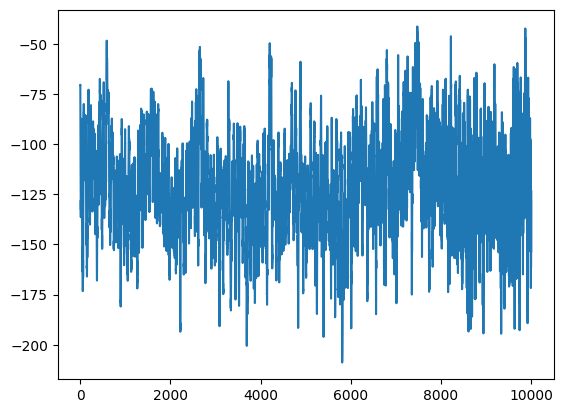

In [92]:
# Takes the 50 second sample of the eeg data
eeg = eeg.loc[eeg_label_offset_seconds : eeg_label_offset_seconds + eeg_duration - 1,]
eeg = eeg.to_numpy()
# Each row represents a time point with all the node.
# Each column represents a node at all time points one by one.
plt.plot(eeg[:,1])

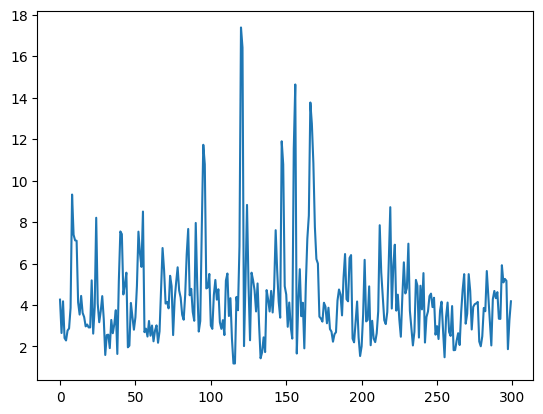

In [93]:
# Takes the 10 minute sample of the spectrogram data
spectrogram = spectrogram.loc[spectrogram_label_offset_seconds : spectrogram_label_offset_seconds + spectrogram_duration - 1,]
spectrogram = spectrogram.to_numpy()[:,1:] # Removing the time column
# Each row represents a time point with all the frequency.
# Each column represents a frequency at all time points one by one.
plt.plot(spectrogram[:,0])

In [94]:
eeg = eeg.T.flatten()
spectrogram = spectrogram.T.flatten()

In [95]:
# Votes for each class
seizure_vote = train_data['seizure_vote'][0]
lpd_vote = train_data['lpd_vote'][0]
gpd_vote = train_data['gpd_vote'][0]
lrda_vote = train_data['lrda_vote'][0]
grda_vote = train_data['grda_vote'][0]
other_vote = train_data['other_vote'][0]

In [96]:
# Defining the new X_train and Y_train
y_train = np.array([seizure_vote, 
                    lpd_vote, 
                    gpd_vote, 
                    lrda_vote, 
                    grda_vote, 
                    other_vote])

x_train = np.array([eeg])
x_train = np.concatenate((x_train, spectrogram), axis=None)

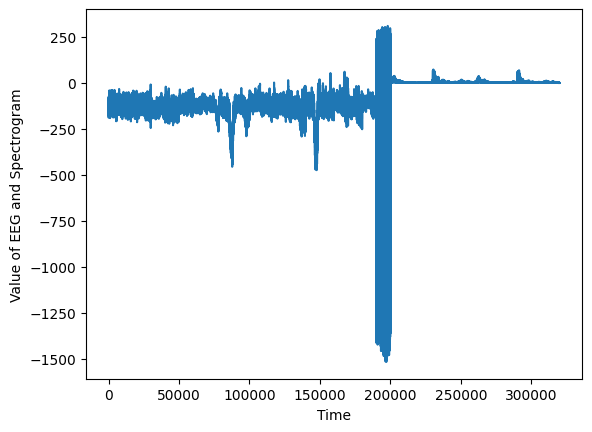

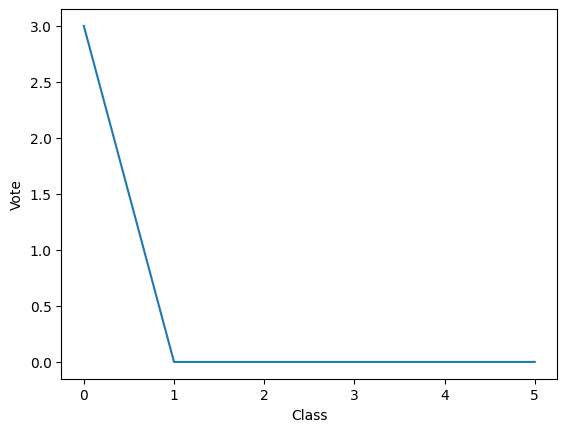

In [97]:
plt.plot(x_train)
plt.xlabel('Time')
plt.ylabel('Value of EEG and Spectrogram')
plt.show()
plt.plot(y_train)
plt.xlabel('Class')
plt.ylabel('Vote')
plt.show()

In [98]:
x_train.size
y_train.size

6

# Getting all the train eeg and spectrogram data

In [99]:
train_csv = pd.read_csv(TRAIN_CSV)

x_train_list = np.empty(0)

for i in range(100):
    data = train_csv.iloc[i]
    eeg_id = data['eeg_id']
    spectrogram_id = data['spectrogram_id']
    eeg_label_offset_seconds = data['eeg_label_offset_seconds']
    spectrogram_label_offset_seconds = data['spectrogram_label_offset_seconds']
    eeg_duration = 10000
    spectrogram_duration = 300
    eeg = pd.read_parquet(TRAIN_EEGS + f'{eeg_id}.parquet')
    spectrogram = pd.read_parquet(TRAIN_SPECTROGRAMS + f'{spectrogram_id}.parquet')
    eeg = eeg.loc[eeg_label_offset_seconds : eeg_label_offset_seconds + eeg_duration - 1,]
    eeg = eeg.to_numpy()
    eeg = eeg.T.flatten()
    spectrogram = spectrogram.loc[spectrogram_label_offset_seconds : spectrogram_label_offset_seconds + spectrogram_duration - 1,]
    spectrogram = spectrogram.to_numpy()[:,1:]
    spectrogram = spectrogram.T.flatten()
    seizure_vote = data['seizure_vote']
    lpd_vote = data['lpd_vote']
    gpd_vote = data['gpd_vote']
    lrda_vote = data['lrda_vote']
    grda_vote = data['grda_vote']
    other_vote = data['other_vote']
    input_data = np.array([seizure_vote, 
                            lpd_vote, 
                            gpd_vote, 
                            lrda_vote, 
                            grda_vote, 
                            other_vote])
    input_data = np.concatenate((input_data, eeg, spectrogram))
    x_train_list = np.append(x_train_list, input_data)

print("Shape of X_Train_List: ", x_train_list.size)

Shape of X_Train_List:  31481000


In [100]:
np.save("X_train_list.npy", x_train_list)

# Running Model

In [101]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
 restore_best_weights=True)

ReduceOnPlateau = keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=10,
)

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
 run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
 return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [102]:
# Model Architecture:
model = keras.models.Sequential([
 keras.layers.Dense(units=3, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=32, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=16, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=1, activation='sigmoid'),
])

In [103]:
# Dummy Data
x_train = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [1, 2, 3]])
y_train = np.array([1, 0, 1, 0, 1])

In [104]:
# Model Compilation
model.compile(loss="mse",
              optimizer="sgd",
              metrics=["accuracy"])


In [105]:
# Model Training
history = model.fit(x_train, y_train, batch_size=3, steps_per_epoch=1,
                    epochs=5,validation_split=0.2,
                    callbacks=[tensorboard_cb,early_stopping_cb,ReduceOnPlateau])

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.6667 - loss: 0.1452 - val_accuracy: 1.0000 - val_loss: 0.1609 - learning_rate: 0.0100
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.2506 - val_accuracy: 1.0000 - val_loss: 0.1630 - learning_rate: 0.0100
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1630 - learning_rate: 0.0100
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6667 - loss: 0.2376 - val_accuracy: 1.0000 - val_loss: 0.1761 - learning_rate: 0.0100
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.2514 - val_accuracy: 1.0000 - val_loss: 0.1745 - learning_rate: 0.0100


2024-03-27 20:14:40.238688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


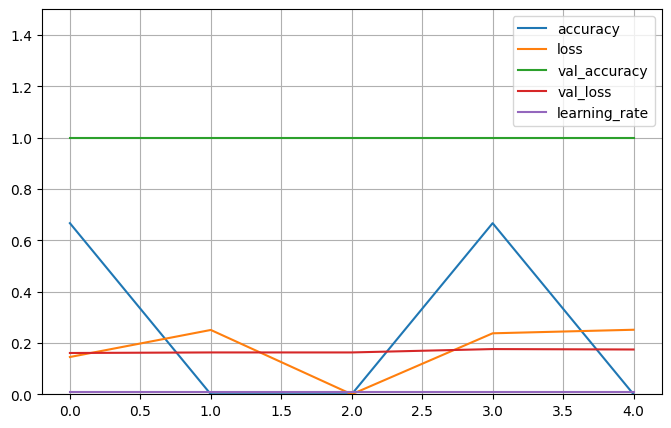

In [106]:
# Plot Metrics
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()